# Diffusion-deformation theories for hydrogels

Author: Jorge Urrea - 2024.01.17

## Introduction

We solve the transient nonlinear chemoelastic problem presented by Bouklas et al. (2015) using Fenics. This model describes the swelling kinetics of polymer gels. In this model both fields are fully coupled and it is assumed that the evolution is quasi-static, thus, the inertial effects are neglected. A staggered approach is adopted.

In [1]:
from dolfin import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Model setup
L = 0.01  # length of the plate
N = 25  # mesh density

mesh = UnitSquareMesh(N,N)

# Scale the mesh to the desired domain size
coordinates = mesh.coordinates()
for coord in coordinates:
    coord *= L

In [3]:
#Defining the model parameters
µ_o = -0.3124#-6 # initial chemical potential
µ_dry = -1.897 # chemical potential when material is dry
µ_swell = -0.00 # chemical potential when material is swollen and in equilibrium

µ_diff = -0.001#0.0 # chemical potential difference (µ - µ_o) (µ = µ_swell when gel is swollen)

In [4]:
# Form compiler options
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True

In [5]:
### Field variable function spaces
element_u = VectorElement('CG', mesh.ufl_cell(), 2) # displacement finite element
element_mu = FiniteElement('CG', mesh.ufl_cell(), 1) # chemical potential finite element
element_Jac = FiniteElement('CG', mesh.ufl_cell(), 1)
V, Q, P = FunctionSpace(mesh, element_u), FunctionSpace(mesh, element_mu), FunctionSpace(mesh, element_Jac)

In [6]:
# Define boundary conditions
class Left(SubDomain):
    def inside(self,x, on_boundary):
        return on_boundary and near(x[0], 0)
class Right(SubDomain):
    def inside(self,x, on_boundary):
        return on_boundary and near(x[0], L)
class Top(SubDomain):
    def inside(self,x, on_boundary):
        return on_boundary and near(x[1], L)
class Bottom(SubDomain):
    def inside(self,x, on_boundary):
        return on_boundary and near(x[1], 0)

# Add boundaries
left = Left()
right = Right()
top = Top()
bottom = Bottom()

boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
top.mark(boundaries,3)
bottom.mark(boundaries,4)

In [7]:
# zero displacement boundary conditions on the symmetric part of the plate
u_bc_bottom = DirichletBC(V.sub(1), Constant(0.0), bottom) 
u_bc_right = DirichletBC(V.sub(0), Constant(0.0), right)
u_bc_left = DirichletBC(V.sub(0), Constant(0.0), left)

# chemical potential on the outer boundaries
mu_bc_top = DirichletBC(Q, Constant(µ_swell), top)
# mu_bc_left = DirichletBC(Q, Constant(µ_diff), left)
mu_bc_right = DirichletBC(Q, Constant(µ_swell), right)

# Jacobian BCs
Jacb_bc_top = DirichletBC(P, Constant(4.2), top)
# mu_bc_left = DirichletBC(Q, Constant(µ_diff), left)
Jacb_bc_right = DirichletBC(P, Constant(4.2), right)

# bcs = [u_bc_bottom, u_bc_right, mu_bc_bottom, mu_bc_right]
# bcs = [u_bc_bottom, u_bc_right, mu_bc_top, mu_bc_left]

bc_u = [u_bc_bottom, u_bc_left, u_bc_right]
bc_mu = [mu_bc_top]#, mu_bc_right] #mu_bc_left]
bc_Jacb = [Jacb_bc_top, Jacb_bc_right]

In [8]:
(du, dµ, dJacb) = TrialFunction(V), TrialFunction(Q), TrialFunction(P)
(v, q, p) = TestFunction(V), TestFunction(Q), TestFunction(P)

(u, µ, Jacb) = Function(V), Function(Q), Function(P)
(uold, µold, Jacb_old) = Function(V), Function(Q), Function(P)

# Create intial conditions and interpolate
# u_init = InitialConditions()
Jacb_init = Expression("1.4", degree=1)
Jacb_old.interpolate(Jacb_init)
Jacb.assign(Jacb_old)

u_init = Expression("-0.035", degree=1)#-0.3124 #-5.71
µold.interpolate(u_init)
µ.assign(µold)

Kinematic quantities

In [9]:
# Model parameters
# Elasticity parameters
G0, χ = Constant(1.7e7), Constant(0.4) # <= Bouklas et al.
K = Constant(100*41143.3342)#Constant(10*41143.3342)#Constant(100*1e4)
NΩ = Constant(1e-3)#Constant(1e-3)#
Ω = Constant(1.7e-28)                          # the volume per solvent molecule
kBT = Constant(1.3806488e-23*298)              # T = 298 K
NkBT = Constant(1e25*1.3806488e-23*298)#Constant(1e4)
D = Constant(2e-3)#Constant(7.4e-11)                          # species diffusivity m^2 s^-1
mc = Constant(0.1)

In [10]:
# Kinematics
d = u.geometric_dimension()
I = Identity(d)                         # Identity tensor

def F(u):
    return variable(I + grad(u)) 

# F = variable(I + grad(u))               # Deformation gradient

# Right Cauchy-Green tensor
def C(u):
    return variable(F(u).T*F(u))
# C = F.T*F     
# 
# Green Lagrange strain tenson
def E(u):
    return variable(grad(u).T + grad(u) + grad(u).T*grad(u))
    # return variable(0.5*(F(u).T*F(u) - I))                        

# Left Cauchy-Green tensor
def B(u):
    return variable(F(u)*F(u).T)

# Invariants of deformation tensors
def Ic(u):
    return variable(tr(F(u).T*F(u)))
 
# Ic = tr(F(u).T*F(u))

def J(u):
    return variable(det(F(u)))

# J  = (det(F)) #1 + Ω*C

In [11]:
def psi_chem(Jacb):
    return variable((1/NΩ)*((Jacb-1)*ln(Jacb/(1 - Jacb)) + χ/Jacb))

def S_(u,Jacb,µ):
    return variable((1/J(u))*(NkBT*F(u) + (-(NkBT/J(u)) + K*(J(u) - kBT*Jacb))*J(u)*inv(F(u).T))*(F(u).T))

def PK1(u,Jacb,µ):
    return variable(J(u)*S_(u,Jacb,µ)*inv(F(u).T))
# PK1 = J(u)*sigma(u,µ)*inv(F(u).T)

# Normalized chemical potential - µ_ = µ/kBT
def µ_(u,Jacb):
    return variable(ln((Jacb - 0.999)/Jacb) + (Jacb + χ)/(0.999*Jacb**2) + (Ω*K/kBT)*(det(F(u)) - Jacb)) 

In [12]:
# Elasticity parameters
# E, nu = 70e3, 0.3
# mu, lmbda = Constant(E/(2*(1 + nu))), Constant(E*nu/((1 + nu)*(1 - 2*nu)))
# Stored strain energy density (compressible neo-Hookean model + chem potential)
def psi(u,µ,Jacb):
    return variable((1/2)*(Ic(u) - 3 - 2*ln(0.999*J(u))) + (K/(2*NkBT))*(det(F(u)) - Jacb)**2)

In [13]:
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

dt = Constant(0.)
# Total potential energy
Psi_n = psi(u,µ,Jacb)*dx# - inner(T, u)*ds
Pi_mech_n = derivative(Psi_n, u, v) 

Jac_n = derivative(Pi_mech_n, u, du) 

# Jacobian implicit equation (for instance concentration)
Pi_Jacb = (-µ + ln((Jacb - 0.999)/Jacb) + (Jacb + χ)/(0.999*Jacb**2) - (Ω*K/kBT)*(det(F(u)) - Jacb))*p*dx

JacJ_n = derivative(Pi_Jacb, Jacb, dJacb)# + derivative(Pi_chem, µ, dµ)

# Mass balance
D = 2.5e-3*kBT # <= Original value that matches the 1D solution
# D = 0.2
def mr(u,Jacb):
    return variable((Jacb - 0.999)*(D/kBT)*inv(B(u)))

alpha_r = 5000.0 # Robin Boundary constant
Pi_chem = (
            (Jacb - Jacb_old)*q*dx
            + dt*inner(mr(u,Jacb)*grad(µ),grad(q))*dx)
            
Jacmu_n = derivative(Pi_chem, µ, dµ)

In [14]:
# 1D NL PDE for lambda - incompressibility constraint lifted

mesh_lambda = UnitIntervalMesh(50)

# Scale the mesh to the desired domain size
coordinates = mesh_lambda.coordinates()
for coord in coordinates:
    coord *= L

element_lambda = FiniteElement('CG', mesh_lambda.ufl_cell(), 2)
P = FunctionSpace(mesh_lambda, element_lambda)

lambda_o = 1.0 # initial chemical potential

dlambda = TrialFunction(P)
p = TestFunction(P)

lamda = Function(P)
lamda_old = Function(P)

# Create initial condition
lamda0 = 1.4
lambda_init = Expression("1.4", degree=1)
lamda_old.interpolate(lambda_init)
lamda.assign(lamda_old)

# BCs
lambda_right = 4.35#4.25
lambda_bc_left = DirichletBC(P, Constant(0.0), left)
labmda_bc_right = DirichletBC(P, Constant(lambda_right), right)

bc_lambda = labmda_bc_right

def gama(lamda):
    return variable( (lamda0**2) + ((NkBT)/(K*(lamda0**2)))*(1  + 1/(lamda**2)) )

def zeta(lamda):
    return variable( (( 1/ (((lamda0**2)*lamda)**2)) - (2*χ*((lamda0**2)*lamda - 1))/((((lamda0**2)*lamda)**3)))
                    * ( (NkBT*(1 + (lamda**2))/(K*(lamda0**2)*(lamda**4))) + ((lamda0**2)/(lamda**2)) )
                     + NΩ*(((lamda0**2)*lamda - 1)*(lamda**2 + 1))/((lamda0**2)*(lamda**4)))

lambda_form = (gama(lamda)*(lamda - lamda_old)/dt*p
               + dot((2.5e-3)*(zeta(lamda))*grad(lamda), grad(p)))*dx

Jac_lambda = derivative(lambda_form, lamda, dlambda)

In [15]:
# Time-stepping
Nincr = 10
t = np.linspace(0, 10, Nincr+1)
Nx = 10
x = np.linspace(0, L, Nx)
µ_res = np.zeros((Nx, Nincr+1))
Jacb_res = np.zeros((Nx, Nincr+1))

lambda_res = np.zeros((Nx, Nincr+1))
syy_array = np.zeros((Nx, Nincr+1))

PK1yy_array = np.zeros((Nx, Nincr+1))

for (i, dti) in enumerate(np.diff(t)):
    print("Increment " + str(i+1))
    dt.assign(dti)
    
    # Compute tentative displacement step
    begin("Computing tentative displacement")
    solve(Pi_mech_n == 0, u, bc_u, J=Jac_n)#, solver_parameters={"newton_solver":
                                        # {"linear_solver": "gmres", "preconditioner": "ilu"}})#, "relative_tolerance": 1e-6, 
                                        # "convergence_criterion": "incremental", "relaxation_parameter": 0.7}})
    uold.assign(u)

    plt.figure()
    p = plot(u, mode="displacement")
    plot(mesh, linewidth=0.7)
    plt.colorbar(p)
    plt.close() 

    end()

    # Jacobian
    begin("Computing Jacobian")
    solve(Pi_Jacb == 0, Jacb)#, bc_Jacb)#, J = JacJ_n)
    # solve(lhs(Pi_chem) == rhs(Pi_chem), Jacb, bc_Jacb)#, 
        # solver_parameters={'linear_solver': 'gmres',
        #                  'preconditioner': 'ilu'})
    Jacb_res[:, i+1] = [Jacb(L/2, xi) for xi in x]

    end()

    # Chemical potential
    begin("Computing chemical potential")
    solve(Pi_chem == 0, µ, bc_mu)#, J = Jacmu_n)#, 
        # solver_parameters={'linear_solver': 'gmres',
        #                  'preconditioner': 'ilu'})
    Jacb_old.assign(Jacb)
    µold.assign(µ)
    µ_res[:, i+1] = [µ(L/2, xi) for xi in x]
    print(µ_res[:, i+1])

    end()

    s_yy = S_(u,Jacb,µ)[0,0]
    syy_P1 = project(s_yy, Q)
    syy_array[:, i+1] = [syy_P1(L/2, xi) for xi in x]  

    PK1yy = PK1(u,Jacb,µ)[1,1]
    PK1yy_P1 = project(PK1yy, Q)
    PK1yy_array[:, i+1] = [PK1yy_P1(L/2, xi) for xi in x]
    

    begin("Computing 1D lambda sol")
    solve(lambda_form == 0, lamda, bc_lambda, J=Jac_lambda)#, 
        # solver_parameters={'linear_solver': 'gmres',
        #                  'preconditioner': 'ilu'})
    lamda_old.assign(lamda)
    lambda_res[:, i+1] = [lamda(xi) for xi in x]
    end()
    
    # Plot solution

    plt.figure()
    p = plot(µ)
    plt.colorbar(p)
    plt.close()

    plt.figure()
    # p = plot((C(u)[1,1])**(1/2), title="$\lambda_2$ stretch in thickness dir")
    p = plot((1 + u[1]), title="$\lambda_2$ stretch in thickness dir")
    plt.colorbar(p)
    plt.close()  

    plt.figure()
    p = plot(S_(u,Jacb,µ)[1,1], title="$S_{yy}/NK_{B}T$ normalized nominal stress")
    plt.colorbar(p)
    plt.close() 
    
    print("t =", dti)


Increment 1
Computing tentative displacement
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 5.951e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 1.643e-04 (tol = 1.000e-10) r (rel) = 2.762e-03 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 6.524e-10 (tol = 1.000e-10) r (rel) = 1.096e-08 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 4.001e-15 (tol = 1.000e-10) r (rel) = 6.723e-14 (tol = 1.000e-09)
    Newton solver finished in 3 iterations and 3 linear solver iterations.
Computing Jacobian
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.156e-06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 3.675e-07 (tol = 1.000e-10) r (rel) = 3.180e-01 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 5.517e-08 (tol = 1.0

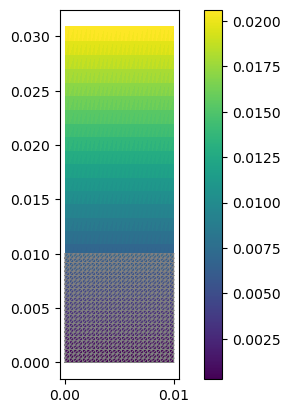

In [16]:
plt.figure()
p = plot(u, mode="displacement")
plot(mesh, linewidth=0.7)
plt.colorbar(p)
plt.show() 

/usr/local/lib/python3.8/dist-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_line0), but could not find a label for it.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_line2), but could not find a label for it.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_line4), but could not find a label for it.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_line6), but could not find a label for it.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_line8), but could not find a label for it.
  warnings.warn(


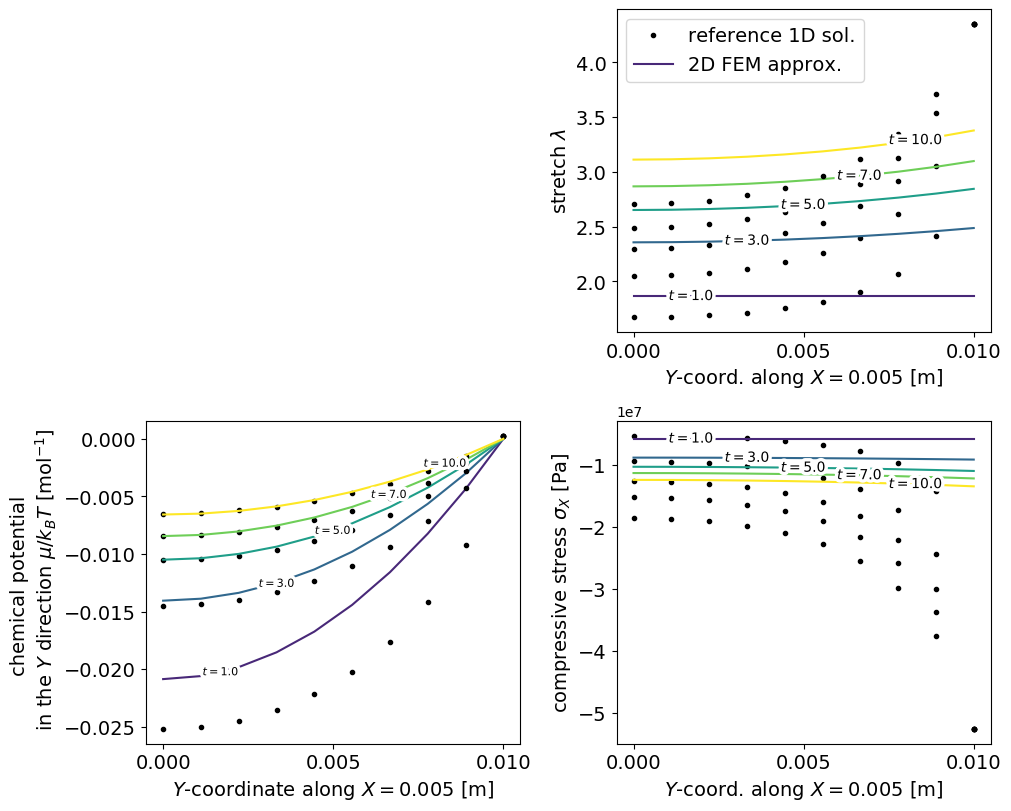

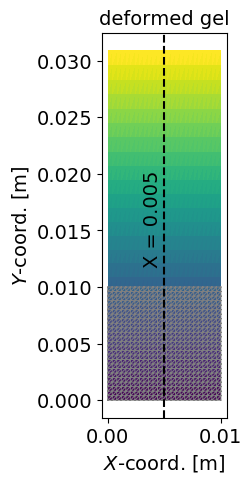

In [17]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from labellines import labelLine, labelLines

fig, axes = plt.subplots(ncols=2, nrows=2, constrained_layout=True, figsize=(10,8))
axes = axes.flatten()

ax = axes[0]
ax.set_visible(False)

# stretch
# fig, ax = plt.subplots()
ax = axes[1]

nValues = np.arange(0,10)
# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=nValues.min(), vmax=nValues.max())
colormap = cm.viridis

for n in [1, 3, 5, 7, 10]:
    ax.plot(x, lambda_res[:, n], 'k.')
    ax.plot(x, Jacb_res[:, n], color=colormap(normalize(n)), label="$t = {:.1f}$".format(t[n]))#, label=str(t[n]))


labelLines(ax.get_lines(), align=False, zorder=2.5, color="k", fontsize=10)
ax.set_xlabel("$Y$-coord. along $X=0.005$ [m]", fontsize=14)
ax.set_ylabel("stretch $\lambda$", fontsize=14)
ax.legend(["reference 1D sol.", "2D FEM approx."], fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

x_ticks = np.linspace(0, 0.01, 3)  # 5 ticks from 0 to 0.01
y_ticks_lambda = np.linspace(1.0, 5.0, 3)  # Example for the lambda_res subplot
ax.set_xticks(x_ticks)

# chemical potential
# fig, ax = plt.subplots()
ax = axes[2]

nValues = np.arange(0,10)
# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=nValues.min(), vmax=nValues.max())
colormap = cm.viridis

chi = 0.4
lambda_x = lambda_res[:, 1::Nincr//10]

mu_x = ((1.3806488e-23*298)*(np.log(((lamda0**2)*lambda_x - 1.01)/((lamda0**2)*lambda_x)) #
                              + ((lamda0**2)*lambda_x + chi)/((lamda0**4)*lambda_x**2))
        + ((1.7e-28)*(1e25*1.3806488e-23*298)/(lamda0**2))*(lambda_x - 1/lambda_x) ) 

for n in [1, 3, 5, 7, 10]:
    ax.plot(x, mu_x[:, n-1]/(1.3806488e-23*298), 'k.')#
    ax.plot(x, µ_res[:, n], color=colormap(normalize(n)), label="$t = {:.1f}$".format(t[n]))#, label=str(t[n]))

labelLines(ax.get_lines(), align=False, zorder=2.5, color="k", fontsize=8)
ax.set_xlabel("$Y$-coordinate along $X=0.005$ [m]", fontsize=14)
ax.set_ylabel("chemical potential \n in the $Y$ direction $\mu/k_B T$ [mol$^{-1}$]", fontsize=14)
# ax.legend(["reference 1D sol.", "2D FEM approx."])
ax.tick_params(axis='both', which='major', labelsize=14)

x_ticks = np.linspace(0, 0.01, 3)  # 5 ticks from 0 to 0.01
y_ticks_mu = np.linspace(0.002, -0.024, 4)  # Example for the lambda_res subplot
ax.set_xticks(x_ticks)
# ax.set_yticks(y_ticks_mu)

ax = axes[3]

nValues = np.arange(0,10)
# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=nValues.min(), vmax=nValues.max())
colormap = cm.viridis

sigma_y = ((1e25*1.3806488e-23*298)*(lamda0 - 1/lamda0) 
           - ((100*1e25*1.3806488e-23*298*lambda_x)/(lamda0))*(lambda_x - 1/lambda_x)) # <= non-normalized

for n in [1, 3, 5, 7, 10]: # PK1yy_array
    ax.plot(x, sigma_y[:, n-1], 'k.')
    ax.plot(x, -syy_array[:, n], color=colormap(normalize(n)), label="$t = {:.1f}$".format(t[n]))#, label=str(t[n]))

labelLines(ax.get_lines(), align=False, zorder=2.5, color="k", fontsize=10)
ax.set_xlabel("$Y$-coord. along $X=0.005$ [m]", fontsize=14)
ax.set_ylabel("compressive stress $\sigma_X$ [Pa]", fontsize=14) 
# ax.legend(["reference 1D sol.", "2D FEM approx."])
ax.tick_params(axis='both', which='major', labelsize=14)

x_ticks = np.linspace(0, 0.01, 3)  # 5 ticks from 0 to 0.01
y_ticks_stress = np.linspace(-5.0e7, -0.9e7, 4)  # Example for the lambda_res subplot
ax.set_xticks(x_ticks)
# ax.set_yticks(y_ticks_stress)

# plt.savefig('results/Bouklas/Fig_refsol_2DFEM_Bouklas_x001.pdf') 
plt.show()

# ax = axes[3]
plt.figure(figsize=(5,5))
p = plot(u, mode="displacement")
plt.axvline(x = 0.005, color = 'k', linestyle = '--', label = 'X = 0.005')
plt.text(0.0040, 0.016, 'X = 0.005', rotation=90, ha='center', va='center', fontsize = 14)
plot(mesh, linewidth=0.7)
# cbar = plt.colorbar(p)#, shrink = 0.5)
# cbar.ax.tick_params(labelsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.xlabel("$X$-coord. [m]", fontsize=14)
plt.ylabel("$Y$-coord. [m]", fontsize=14)
# plt.legend(frameon=False, fontsize=14, loc='best')
# plt.legend(["deformed gel"])
plt.title("deformed gel", fontsize = 14)
# plt.savefig('results/Bouklas/Fig_2DFEM_def_gel_Bouklas_x001.pdf')  
plt.show() 